**Autor**: Álysson Soares

# Montar o drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configurando o PySpark

In [3]:
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [5]:
import findspark
findspark.init()

Criando a sessão Spark

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Desafio 1") \
    .getOrCreate()

In [7]:
spark

# Contexto

## Contexto do Desafio

A House Rocket é uma plataforma digital que tem como modelo de negócio, a compra e a venda de imóveis usando tecnologia.

Você é um Data Scientist contrato pela empresa para ajudar a encontrar as melhores oportunidades de negócio no mercado de imóveis. O CEO da House Rocket gostaria de maximizar a receita da empresa encontrando boas oportunidades de negócio.

Sua principal estratégia é comprar boas casas em ótimas localizações com preços baixos e depois revendê-las posteriormente à preços mais altos. Quanto maior a diferença entre a compra e a venda, maior o lucro da empresa e portanto maior sua receita.

Entretanto, as casas possuem muitos atributos que as tornam mais ou menos atrativas aos compradores e vendedores e a localização e o período do ano também podem influenciar os preços.

Portanto, seu trabalho como Data Scientist é responder as seguinte perguntas:

1.   Quais casas o CEO da House Rocket deveria comprar e por qual preço de compra?
2.   Uma vez a casa em posse da empresa, qual o melhor momento para vendê-las e qual seria o preço da venda?
3. A House Rocket deveria fazer uma reforma para aumentar o preço da venda? Quais seriam as sugestões de mudanças? Qual o incremento no preço dado por cada opção de reforma?




## Descrição da base

**id**: Numeração única de identificação de cada imóvel

**date**: Data em que a casa foi vendida

**price**: Preço que a casa está sendo vendida pelo proprietário (alvo)

**bedrooms**: Número de quartos

**bathrooms**: Número de banheiros (0.5 = banheiro em um quarto, mas sem chuveiro)

**sqft_living**: Medida (em pés quadrado) do espaço interior dos apartamentos

**sqft_lot**: Medida (em pés quadrado)quadrada do espaço terrestre

**floors**: Número de andares do imóvel

**waterfront**: Variável que indica a presença ou não de vista para água (0 = não e 1 = sim)

**view**: Um índice de 0 a 4 que indica a qualidade da vista da propriedade. Varia de 0 a 4, onde: 0 = baixa 4 = alta

**condition**: Um índice de 1 a 5 que indica a condição da casa. Varia de 1 a 5, onde: 1 = baixo |-| 5 = alta

**grade**: Um índice de 1 a 13 que indica a construção e o design do edifício. Varia de 1 a 13, onde: 1-3 = baixo, 7 = médio e 11-13 = alta

**sqft_above**: A metragem quadrada do espaço habitacional interior acima do nível do solo

**sqft_basement**: A metragem quadrada do espaço habitacional interior abaixo do nível do solo

**yr_built**: Ano de construção

**yr_renovated**: Ano em que a casa foi reformada

**zipcode**: CEP

**lat**: Coordenada de latitude

**long**: Coordenada de longitude

**sqft_living15**: Medida (em pés quadrado) do espaço interno de habitação para os 15 vizinhos mais próximo

**sqft_lot15**: Medida (em pés quadrado) dos lotes de terra dos 15 vizinhos mais próximo

# Código - Solução

In [ ]:
df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Ciência de Dados - Projetos/House Rocket/kc_house_data.csv", header=True)
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- price: string (nullable = true)
 |-- bedrooms: string (nullable = true)
 |-- bathrooms: string (nullable = true)
 |-- sqft_living: string (nullable = true)
 |-- sqft_lot: string (nullable = true)
 |-- floors: string (nullable = true)
 |-- waterfront: string (nullable = true)
 |-- view: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sqft_above: string (nullable = true)
 |-- sqft_basement: string (nullable = true)
 |-- yr_built: string (nullable = true)
 |-- yr_renovated: string (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- sqft_living15: string (nullable = true)
 |-- sqft_lot15: string (nullable = true)



In [ ]:
# Contar colunas e linhas
n_rows = df.count()
n_cols = len(df.columns)

print('Rows: {} \nColumns: {}'.format(n_rows, n_cols))


Rows: 21613 
Columns: 21


In [ ]:
df.show(5)

+----------+---------------+------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|        id|           date| price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|
+----------+---------------+------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|7129300520|20141013T000000|221900|       3|        1|       1180|    5650|     1|         0|   0|        3|    7|      1180|            0|    1955|           0|  98178|47.5112|-122.257|         1340|      5650|
|6414100192|20141209T000000|538000|       3|     2.25|       2570|    7242|     2|         0|   0|        3|    7|      2170|          400|    1951|    

Ao analisar o tipo dos dados, é importante colocar todos com a sua tipagem correta e não deixá-los como "string".

## Convertendo os tipos de dados

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, col, regexp_replace
from pyspark.sql.types import DateType

Convertendo a coluna de data

In [ ]:
df = df.withColumn('date', regexp_replace('date', 'T000000', '').alias('date'))

In [ ]:
df = df.withColumn('date', to_date(col('date'), 'yyyyMMdd'))

In [ ]:
df.show(5)

+----------+----------+------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|        id|      date| price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|
+----------+----------+------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|7129300520|2014-10-13|221900|       3|        1|       1180|    5650|     1|         0|   0|        3|    7|      1180|            0|    1955|           0|  98178|47.5112|-122.257|         1340|      5650|
|6414100192|2014-12-09|538000|       3|     2.25|       2570|    7242|     2|         0|   0|        3|    7|      2170|          400|    1951|        1991|  98125| 47.721|

In [ ]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- price: string (nullable = true)
 |-- bedrooms: string (nullable = true)
 |-- bathrooms: string (nullable = true)
 |-- sqft_living: string (nullable = true)
 |-- sqft_lot: string (nullable = true)
 |-- floors: string (nullable = true)
 |-- waterfront: string (nullable = true)
 |-- view: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sqft_above: string (nullable = true)
 |-- sqft_basement: string (nullable = true)
 |-- yr_built: string (nullable = true)
 |-- yr_renovated: string (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- sqft_living15: string (nullable = true)
 |-- sqft_lot15: string (nullable = true)



Convertendo colunas para float

In [ ]:
float_columns = ['price', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above',
                 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


In [ ]:
def change_column_type(data_frame, column_list, type_cast='double'):
  for column in column_list:
    data_frame = data_frame.withColumn(column, col(column).cast(type_cast))

  return data_frame

In [ ]:
df = change_column_type(df, float_columns)

In [ ]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: string (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: double (nullable = true)
 |-- sqft_lot: double (nullable = true)
 |-- floors: string (nullable = true)
 |-- waterfront: string (nullable = true)
 |-- view: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sqft_above: double (nullable = true)
 |-- sqft_basement: double (nullable = true)
 |-- yr_built: string (nullable = true)
 |-- yr_renovated: string (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: double (nullable = true)
 |-- sqft_lot15: double (nullable = true)



In [ ]:
df.show(10)

+----------+----------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|        id|      date|    price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|
+----------+----------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|7129300520|2014-10-13| 221900.0|       3|        1|     1180.0|  5650.0|     1|         0|   0|        3|    7|    1180.0|          0.0|    1955|           0|  98178|47.5112|-122.257|       1340.0|    5650.0|
|6414100192|2014-12-09| 538000.0|       3|     2.25|     2570.0|  7242.0|     2|         0|   0|        3|    7|    2170.0|        400.0|    1951|        1991| 

Convertendo colunas para inteiros

In [ ]:
int_columns = ['bedrooms', 'floors', 'waterfront', 'view',
               'condition', 'grade', 'yr_built',  'yr_renovated',
               'zipcode']

In [ ]:
df = change_column_type(df, int_columns, type_cast='int')

In [ ]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: double (nullable = true)
 |-- sqft_lot: double (nullable = true)
 |-- floors: integer (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: double (nullable = true)
 |-- sqft_basement: double (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: double (nullable = true)
 |-- sqft_lot15: double (nullable = true)



Com os dados convertidos, o próximo passo é fazer a limpeza

## Limpeza dos dados

Buscando dados nulos e NaN

In [ ]:
from pyspark.sql.functions import isnan, when, count, col, isnull

In [ ]:
# Contar quantidade de nulos nas colunas
df.select(
    [count(when(isnull(c), c)).alias(c) for c in df.columns]
    ).show()

+---+----+-----+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+---+----+-------------+----------+
| id|date|price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|lat|long|sqft_living15|sqft_lot15|
+---+----+-----+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+---+----+-------------+----------+
|  0|   0|    0|       0|        0|          0|       0|     0|         0|   0|        0|    0|         0|            0|       0|           0|      0|  0|   0|            0|         0|
+---+----+-----+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+---+----+-------------+----------+



In [ ]:
# Contar quantidade de NaN nas colunas que não são a de data
df.select(
    [count(when(isnan(c), c)).alias(c) for c in df.columns if c != 'date']
    ).show()

+---+-----+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+---+----+-------------+----------+
| id|price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|lat|long|sqft_living15|sqft_lot15|
+---+-----+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+---+----+-------------+----------+
|  0|    0|       0|        0|          0|       0|     0|         0|   0|        0|    0|         0|            0|       0|           0|      0|  0|   0|            0|         0|
+---+-----+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+---+----+-------------+----------+



Nenhuma coluna tem dados faltantes, podemos seguir a limpeza e tratamento dos dados.

Outro tratamento importante é eliminar dados duplicados.

In [ ]:
df.dropDuplicates().show()

+----------+----------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|        id|      date|    price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|
+----------+----------+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|3574800520|2014-06-20| 441000.0|       3|     2.75|     1910.0|  7280.0|     1|         0|   0|        3|    7|    1160.0|        750.0|    1979|           0|  98034|47.7319|-122.224|       1710.0|    8152.0|
|1836980160|2015-03-24| 807100.0|       4|      2.5|     2680.0|  4499.0|     2|         0|   0|        3|    9|    2680.0|          0.0|    1999|           0| 

## Análise descritiva dos dados

Tirando as primeiras medidas estatísticas da base

In [ ]:
df.describe().show()

+-------+--------------------+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-----------------+------------------+
|summary|                  id|             price|         bedrooms|         bathrooms|       sqft_living|          sqft_lot|            floors|          waterfront|               view|         condition|             grade|        sqft_above|     sqft_basement|          yr_built|      yr_renovated|           zipcode|                lat|               long|    sqft_living15|        sqft_lot15|
+-------+--------------------+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+-------

Observando as estatísticas é possível notar algumas coisas:
1. A coluna 'bedrooms' possui o valor máximo de 33, o que é algo estranho para um imóvel. Esse tipo de dado pode ser um *outlier* ou apenas um erro nos dados.
2. Na coluna de 'yr_renovated' quando o valor é 0 indica que não houve reforma na casa desde a sua construção.


Para o primeiro caso, é possível dropar registros com essas características ('bedrooms' = 33) desde que não sejam uma quantidade expressiva na base.

In [ ]:
# Quantidade de dados antes
qtd_total = df.count()
qtd_total

21613

In [ ]:
df[df['bedrooms'] == 33].show()

+----------+----------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|        id|      date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|
+----------+----------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|2402100895|2014-06-25|640000.0|      33|     1.75|     1620.0|  6000.0|     1|         0|   0|        5|    7|    1040.0|        580.0|    1947|           0|  98103|47.6878|-122.331|       1330.0|    4700.0|
+----------+----------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+------

Analisando as características desse imóvel, podemos supor que é realmente um erro nos dados, visto que são 33 quartos e apenas 1.75 banheiros.

Dito isso, podemos dropar esse dado.

In [ ]:
df = df[df['bedrooms'] != 33]

In [ ]:
# salvando os dados já tratados
df.toPandas().to_csv('/content/drive/MyDrive/Colab Notebooks/Ciência de Dados - Projetos/House Rocket/kc_house_data_clear.csv',
                     header=True, index=False)

## Hipóteses sobre os dados a serem estudados

**H1** - Imóveis com a vista para o mar são mais caros em pelo menos 20%.

**H2** - Imóveis com a data de construção antes de 1950 são, no mínimo, mais baratos em 20%.

**H3** - As casas reformadas num prazo de até 10 anos tem um maior valor em média 25%.

**H4** - Os imóveis com mais de 4 banheiros são mais caros em, no mínimo, 50%.

**H5** - Imóveis construídos nos 2000 são, pelo menos, 30% mais caros do que imóveis construídos nos anos de 1980.

**H6** - Casas com vista para o mar e que foram vendidas no verão possuem em média 30% mais caras que as nas mesmas condições, mas sem vista para o mar.

**H7** - A estação do ano influencia no preço de venda.

In [ ]:
# Lendo os dados limpos
df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/Ciência de Dados - Projetos/House Rocket/kc_house_data_clear.csv', header=True)
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- price: string (nullable = true)
 |-- bedrooms: string (nullable = true)
 |-- bathrooms: string (nullable = true)
 |-- sqft_living: string (nullable = true)
 |-- sqft_lot: string (nullable = true)
 |-- floors: string (nullable = true)
 |-- waterfront: string (nullable = true)
 |-- view: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sqft_above: string (nullable = true)
 |-- sqft_basement: string (nullable = true)
 |-- yr_built: string (nullable = true)
 |-- yr_renovated: string (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- sqft_living15: string (nullable = true)
 |-- sqft_lot15: string (nullable = true)



In [ ]:
df.show(5)

+----------+----------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|        id|      date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|
+----------+----------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|7129300520|2014-10-13|221900.0|       3|      1.0|     1180.0|  5650.0|     1|         0|   0|        3|    7|    1180.0|          0.0|    1955|           0|  98178|47.5112|-122.257|       1340.0|    5650.0|
|6414100192|2014-12-09|538000.0|       3|     2.25|     2570.0|  7242.0|     2|         0|   0|        3|    7|    2170.0|        400.0|    1951|        1991|  9812

In [9]:
import seaborn as sns
from pyspark.sql import functions as F

### H1: Imóveis com a vista para o mar são mais caros em pelo menos 20%.

In [ ]:
h1 = df.select('price', 'waterfront').groupby('waterfront').agg(F.round(F.mean('price'), 2).alias('mean_price'))

In [ ]:
h1.show()

+----------+----------+
|waterfront|mean_price|
+----------+----------+
|         0| 531558.54|
|         1|1661876.02|
+----------+----------+



<Axes: xlabel='waterfront', ylabel='mean_price'>

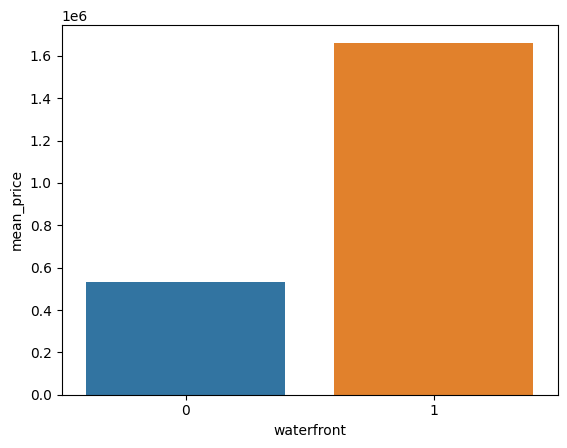

In [ ]:
sns.barplot(data=h1.toPandas(), x='waterfront', y='mean_price')

Observando o gráfico e tabela gerada, é possível notar que o valor dos imóveis com vista para o mar estão acima dos 20% mais caros. O que torna a H1 **VERDADEIRA**.

### H2: Imóveis com a data de construção antes de 1950 são, no mínimo, mais baratos em 20%.

In [ ]:
# Criando dataframe parcial com a condição da H2
new_df = df.withColumn('yr_built_1950', F.when(df.yr_built > 1950, 1).otherwise(0))

In [ ]:
h2 = new_df.select('price', 'yr_built_1950').groupby('yr_built_1950').agg(F.round(F.mean('price')).alias('mean_price'))

In [ ]:
h2.show(5)

+-------------+----------+
|yr_built_1950|mean_price|
+-------------+----------+
|            1|  538889.0|
|            0|  543868.0|
+-------------+----------+



<Axes: xlabel='yr_built_1950', ylabel='mean_price'>

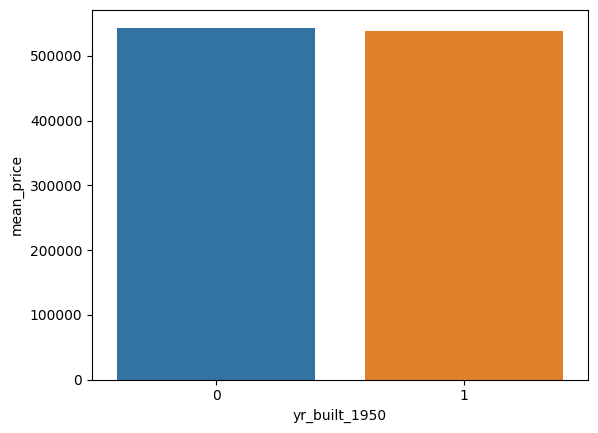

In [ ]:
sns.barplot(data=h2.toPandas(), x='yr_built_1950', y='mean_price')

Os preços médios são próximos, menos de 2% de diferença entre os imóveis construídos antes e depois de 1950. Deste modo, a H2 é **FALSA**.

### H3: As casas reformadas num prazo de até 10 anos tem um maior valor em média 25%.

O ano máximo de reforma segundo o describe usado anteriormente é de 2015, logo, iremos investigar no range de 2005 para cima.

In [ ]:
# Criar dataframe parcial com a H3
new_df = df.withColumn('yr_renovated_10_years_ago', F.when(df.yr_renovated > 2005, 1).otherwise(0))

In [ ]:
h3 = new_df.select('price', 'yr_renovated_10_years_ago').groupby('yr_renovated_10_years_ago').agg(F.round(F.mean('price'), 2).alias('mean_price'))

In [ ]:
h3.show()

+-------------------------+----------+
|yr_renovated_10_years_ago|mean_price|
+-------------------------+----------+
|                        1| 751091.18|
|                        0| 537263.75|
+-------------------------+----------+



<Axes: xlabel='yr_renovated_10_years_ago', ylabel='mean_price'>

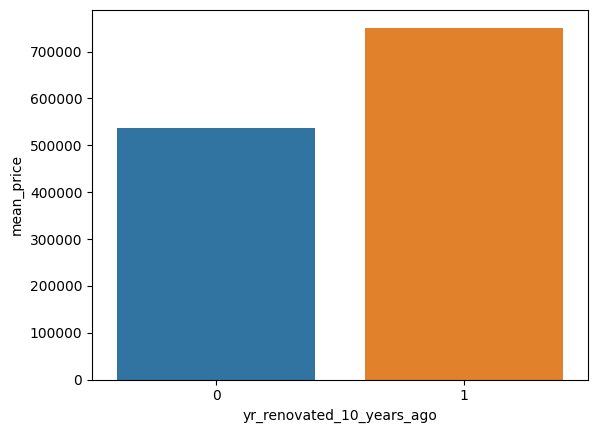

In [ ]:
sns.barplot(data=h3.toPandas(), x='yr_renovated_10_years_ago', y='mean_price')

In [ ]:
# Calculando o percentual...
perc = (537263.75 * 100)/751091.18
print('Percentual: ', str(perc))

Percentual:  71.53109559880599


Podemos evidenciar que o aumento do preço para imóveis reformados até 10 anos (2005 - 2015) possuem um maior valor em média de 19,5%.

Desse modo, a H3 é **FALSA**.

### H4: Os imóveis com mais de 4 banheiros são mais caros em média de 50%.

In [ ]:
# Criando o dataframe auxiliar
new_df = df.withColumn('more_than_4_bathrooms', F.when(df.bathrooms > 4, 1).otherwise(0))

In [ ]:
h4 = new_df.select('price', 'more_than_4_bathrooms').groupby('more_than_4_bathrooms').agg(F.round(F.mean('price'), 2).alias('mean_price'))

In [ ]:
h4.show()

+---------------------+----------+
|more_than_4_bathrooms|mean_price|
+---------------------+----------+
|                    1|2250476.88|
|                    0| 535003.46|
+---------------------+----------+



<Axes: xlabel='more_than_4_bathrooms', ylabel='mean_price'>

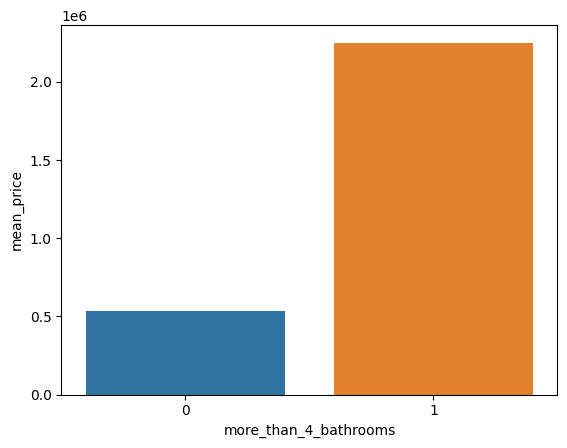

In [ ]:
sns.barplot(data=h4.toPandas(), x='more_than_4_bathrooms', y='mean_price')

In [ ]:
# Calculando o percentual...
def calc_perc(total_value, partial_value):
  perc = round((partial_value * 100)/total_value, 2)
  print('O valor parcial representa {}% do total.'.format(str(perc)))

In [ ]:
calc_perc(2250476.88, 535003.46)

O valor parcial representa 23.77% do total.


Sendo assim, os imóveis com mais de 4 banheiros tem um valor acima de 50% dos demais, o que torna a H4 **VERDADEIRA**.

### H5: Imóveis construídos nos 2000 são 30% mais caros do que imóveis construídos nos anos de 1980

In [22]:
from pyspark.sql.functions import when

In [ ]:
# Para os anos 2000 (2000 - 2009) irei chamar de categoria A
# Para os anos 1980 (1980 - 1989) irei chamar de categoria B
new_df = df.withColumn('year_range', when((df.yr_built >= 2000) & (df.yr_built < 2009), 'A')\
                       .when((df.yr_built >= 1980) & (df.yr_built < 1989), 'B')
                       .otherwise('C'))

In [ ]:
h5 = new_df.select('price', 'yr_built', 'year_range')

In [ ]:
h5.show(5)

+--------+--------+----------+
|   price|yr_built|year_range|
+--------+--------+----------+
|221900.0|    1955|         C|
|538000.0|    1951|         C|
|180000.0|    1933|         C|
|604000.0|    1965|         C|
|510000.0|    1987|         B|
+--------+--------+----------+
only showing top 5 rows



In [ ]:
h5 = h5.select('price', 'year_range').groupby('year_range').agg(F.round(F.mean('price'), 2).alias('mean_price'))

In [ ]:
h5.show()

+----------+----------+
|year_range|mean_price|
+----------+----------+
|         B| 519185.39|
|         C| 526653.74|
|         A| 619452.22|
+----------+----------+



<Axes: xlabel='year_range', ylabel='mean_price'>

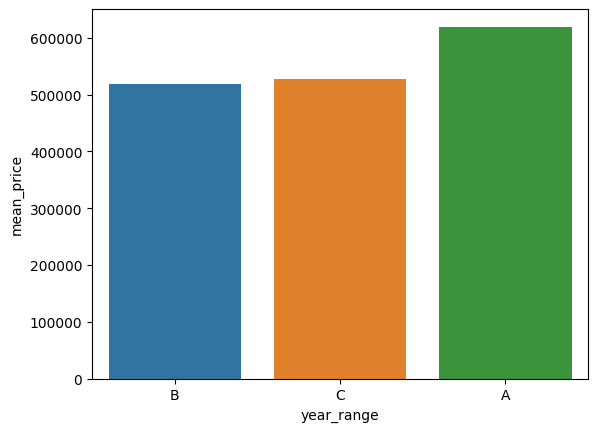

In [ ]:
sns.barplot(data=h5.toPandas(), x='year_range', y='mean_price')

In [ ]:
calc_perc(619452.22, 519185.39)

O valor parcial representa 83.81% do total.


Sendo assim, os imóveis construídos nos anos 80 não apenas 17,19% mais baratos que os dos anos 2000, o que torna a H5 **FALSA**.

### H6: Casas com vista para o mar e que foram vendidas no verão possuem em média 30% mais caras que as nas mesmas condições, mas sem vista para o mar.

Estações do ano no Hemisfério Norte (em meses):

*   Verão: Junho a Agosto
*   Outono: Setembro a Novembro
*   Inverno: Dezembro a Fevereiro
*   Primaveira: Março a Maio


In [ ]:
new_df = df.withColumn('season',
                       when((F.month(df.date) >= 3) & (F.month(df.date) < 6), 'spring')\
                       .when((F.month(df.date) >= 6) & (F.month(df.date) < 9), 'summer')\
                       .when((F.month(df.date) >= 9) & (F.month(df.date) < 12), 'fall')\
                       .otherwise('winter'))

In [ ]:
h6 = new_df.select('season', 'price', 'waterfront').groupby('season', 'waterfront').agg(F.round(F.mean('price'), 2).alias('mean_price'))

In [ ]:
h6.show()

+------+----------+----------+
|season|waterfront|mean_price|
+------+----------+----------+
|summer|         0| 537407.81|
|  fall|         0| 520964.12|
|winter|         1|1534211.54|
|spring|         0| 545164.74|
|summer|         1|1825345.65|
|winter|         0| 512036.44|
|  fall|         1|1608672.65|
|spring|         1|1622921.11|
+------+----------+----------+



In [ ]:
calc_perc(1825345.65, 537407.81)

O valor parcial representa 29.44% do total.


O preço dos imóveis com vista para o mar e vendidos no verão são 70% mais caras que as que não tem vista para o mar e também foram vendidas no verão.

Portanto, H6 é **VERDADEIRA**.

### H7: A estação do ano influencia no preço de venda.

In [ ]:
new_df = df.withColumn('season',
                       when((F.month(df.date) >= 3) & (F.month(df.date) < 6), 'spring')\
                       .when((F.month(df.date) >= 6) & (F.month(df.date) < 9), 'summer')\
                       .when((F.month(df.date) >= 9) & (F.month(df.date) < 12), 'fall')\
                       .otherwise('winter'))

In [ ]:
h7 = new_df.select('season', 'price').groupby('season').agg(F.round(F.mean('price'), 2).alias('mean_price'))

In [ ]:
h7.show()

+------+----------+
|season|mean_price|
+------+----------+
|winter| 519221.24|
|summer| 546767.23|
|spring| 552603.24|
|  fall| 530846.52|
+------+----------+



<Axes: xlabel='season', ylabel='mean_price'>

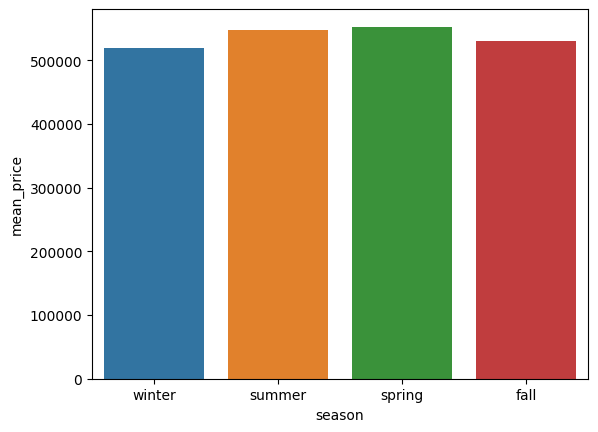

In [ ]:
sns.barplot(data=h7.toPandas(), x='season', y='mean_price')

Apesar de haver uma variação no valor das vendas por estações, não parece ter uma influência considerável no preço. Podemos considerar essa hipótese H7 **FALSA**.

## Questões do negócio

Construindo os *pipelines* para responder as perguntas que foram feitas para o *case*.

In [8]:
# Lendo os dados limpos
df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/Ciência de Dados - Projetos/House Rocket/kc_house_data_clear.csv', header=True)
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- price: string (nullable = true)
 |-- bedrooms: string (nullable = true)
 |-- bathrooms: string (nullable = true)
 |-- sqft_living: string (nullable = true)
 |-- sqft_lot: string (nullable = true)
 |-- floors: string (nullable = true)
 |-- waterfront: string (nullable = true)
 |-- view: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sqft_above: string (nullable = true)
 |-- sqft_basement: string (nullable = true)
 |-- yr_built: string (nullable = true)
 |-- yr_renovated: string (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- sqft_living15: string (nullable = true)
 |-- sqft_lot15: string (nullable = true)



### Quais casas o CEO da House Rocket deveria comprar e por qual preço de compra?

O que faz mais sentido em relação aos lucros seria comprar uma casa com boas condições e que tivesse um preço abaixo do preço médio.

In [36]:
mean_price = df.select('price').agg(F.round(F.mean('price'), 2).alias('mean_price')).first()['mean_price']

In [37]:
mean_price

540083.52

In [38]:
df_to_buy = df.withColumn('to_buy',
                       when((df.price <= mean_price) & (df.condition >= 3), 'YES')\
                       .otherwise('NO'))

In [39]:
df_to_buy.show(5)

+----------+----------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+------+
|        id|      date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|to_buy|
+----------+----------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+------+
|7129300520|2014-10-13|221900.0|       3|      1.0|     1180.0|  5650.0|     1|         0|   0|        3|    7|    1180.0|          0.0|    1955|           0|  98178|47.5112|-122.257|       1340.0|    5650.0|   YES|
|6414100192|2014-12-09|538000.0|       3|     2.25|     2570.0|  7242.0|     2|         0|   0|        3|    7|    2170.0|        400.0|

In [40]:
# Imoveis para comprar
df_to_buy.select('*').where(df_to_buy.to_buy == 'YES').show()

+----------+----------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+------+
|        id|      date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|to_buy|
+----------+----------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+------+
|7129300520|2014-10-13|221900.0|       3|      1.0|     1180.0|  5650.0|     1|         0|   0|        3|    7|    1180.0|          0.0|    1955|           0|  98178|47.5112|-122.257|       1340.0|    5650.0|   YES|
|6414100192|2014-12-09|538000.0|       3|     2.25|     2570.0|  7242.0|     2|         0|   0|        3|    7|    2170.0|        400.0|

### Uma vez a casa em posse da empresa, qual o melhor momento para vendê-las e qual seria o preço da venda?

Ao fazermos a análise da **H7**, percebemos que os imóveis durante o verão e primavera possuiam um maior valor em relação as outras duas estações.

E para considerar o melhor valor de venda, um bom lucro seria em torno de 15% para as casas vendidas no outono/inverno e 30% para casas vendidas no verão/primavera.

Sendo assim, podemos pré-processar a base para gerar um novo DF com as informações de estações e seus preços.

In [41]:
df_to_sold = df_to_buy.withColumn('season',
                       when((F.month(df_to_buy.date) >= 3) & (F.month(df_to_buy.date) < 6), 'spring')\
                       .when((F.month(df_to_buy.date) >= 6) & (F.month(df_to_buy.date) < 9), 'summer')\
                       .when((F.month(df_to_buy.date) >= 9) & (F.month(df_to_buy.date) < 12), 'fall')\
                       .otherwise('winter'))

In [45]:
df_to_sold = df_to_sold.withColumn('price_to_sold',
                            when((df_to_sold.season == 'spring') | (df_to_sold.season == 'summer'), F.round(df_to_sold.price * 1.25, 2))\
                            .otherwise(F.round(df_to_sold.price * 1.15,2)))

In [46]:
df_to_sold.show(5)

+----------+----------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+------+------+-------------+
|        id|      date|   price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|to_buy|season|price_to_sold|
+----------+----------+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+------+------+-------------+
|7129300520|2014-10-13|221900.0|       3|      1.0|     1180.0|  5650.0|     1|         0|   0|        3|    7|    1180.0|          0.0|    1955|           0|  98178|47.5112|-122.257|       1340.0|    5650.0|   YES|  fall|     255185.0|
|6414100192|2014-12-09|538000.0|       3|     2.25| 

### A House Rocket deveria fazer uma reforma para aumentar o preço da venda? Quais seriam as sugestões de mudanças? Qual o incremento no preço dado por cada opção de reforma?

Com a análise dos dados na H3, é possível perceber que casas reformadas nos últimos anos 10 possuem um maior valor. Deste modo, a reforma da casa é um opção para melhoria do valor.


O número de banheiros também influencia no valor das casas, então juntamente com a reforma, a adição de mais banheiros no imóvel seria uma opção para o aumento do valor.